## Brunel Wang example from Brian2 website, with some edits

First, allow matplotlib to plot inline

Import brian2 and set some variables

In [1]:

%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
from brian2 import *
# populations
N = 1000
N_E = int(N * 0.8)  # pyramidal neurons
N_I = int(N * 0.2)  # interneurons

# voltage
V_L = -70. * mV
V_thr = -50. * mV
V_reset = -55. * mV
V_E = 0. * mV
V_I = -70. * mV

# membrane capacitance
C_m_E = 0.5 * nF
C_m_I = 0.2 * nF

# membrane leak
g_m_E = 25. * nS
g_m_I = 20. * nS

# refractory period
tau_rp_E = 2. * ms
tau_rp_I = 1. * ms

# external stimuli
rate = 3 * Hz
C_ext = 800

# synapses
C_E = N_E
C_I = N_I

# AMPA (excitatory)
g_AMPA_ext_E = 2.08 * nS
g_AMPA_rec_E = 0.104 * nS * 800. / N_E
g_AMPA_ext_I = 1.62 * nS
g_AMPA_rec_I = 0.081 * nS * 800. / N_E
tau_AMPA = 2. * ms

# NMDA (excitatory)
g_NMDA_E = 0.327 * nS * 800. / N_E
g_NMDA_I = 0.258 * nS * 800. / N_E
tau_NMDA_rise = 2. * ms
tau_NMDA_decay = 100. * ms
alpha = 0.5 / ms
Mg2 = 1.

# GABAergic (inhibitory)
g_GABA_E = 1.25 * nS * 200. / N_I
g_GABA_I = 0.973 * nS * 200. / N_I
tau_GABA = 10. * ms

# subpopulations
f = 0.1
p = 5
N_sub = int(N_E * f)
N_non = int(N_E * (1. - f * p))
w_plus = 2.1
w_minus = 1. - f * (w_plus - 1.) / (1. - f)

# modeling
eqs_E = '''
dv / dt = (- g_m_E * (v - V_L) - I_syn) / C_m_E : volt (unless refractory)

I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

I_AMPA_ext = g_AMPA_ext_E * (v - V_E) * s_AMPA_ext : amp
I_AMPA_rec = g_AMPA_rec_E * (v - V_E) * 1 * s_AMPA : amp
ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

I_NMDA_rec = g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
s_NMDA_tot : 1

I_GABA_rec = g_GABA_E * (v - V_I) * s_GABA : amp
ds_GABA / dt = - s_GABA / tau_GABA : 1
'''

eqs_I = '''
dv / dt = (- g_m_I * (v - V_L) - I_syn) / C_m_I : volt (unless refractory)

I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

I_AMPA_ext = g_AMPA_ext_I * (v - V_E) * s_AMPA_ext : amp
I_AMPA_rec = g_AMPA_rec_I * (v - V_E) * 1 * s_AMPA : amp
ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

I_NMDA_rec = g_NMDA_I * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
s_NMDA_tot : 1

I_GABA_rec = g_GABA_I * (v - V_I) * s_GABA : amp
ds_GABA / dt = - s_GABA / tau_GABA : 1
'''

P_E = NeuronGroup(N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_E, method='euler')
P_E.v = V_L
P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_I, method='euler')
P_I.v = V_L

eqs_glut = '''
s_NMDA_tot_post = w * s_NMDA : 1 (summed)
ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1 (clock-driven)
dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
w : 1
'''

eqs_pre_glut = '''
s_AMPA += w
x += 1
'''

eqs_pre_gaba = '''
s_GABA += 1
'''

eqs_pre_ext = '''
s_AMPA_ext += 1
'''

# E to E
C_E_E = Synapses(P_E, P_E, model=eqs_glut, on_pre=eqs_pre_glut, method='euler')
C_E_E.connect('i != j')
C_E_E.w[:] = 1

for pi in range(N_non, N_non + p * N_sub, N_sub):

    # internal other subpopulation to current nonselective
    C_E_E.w[C_E_E.indices[:, pi:pi + N_sub]] = w_minus

    # internal current subpopulation to current subpopulation
    C_E_E.w[C_E_E.indices[pi:pi + N_sub, pi:pi + N_sub]] = w_plus

# E to I
C_E_I = Synapses(P_E, P_I, model=eqs_glut, on_pre=eqs_pre_glut, method='euler')
C_E_I.connect()
C_E_I.w[:] = 1

# I to I
C_I_I = Synapses(P_I, P_I, on_pre=eqs_pre_gaba, method='euler')
C_I_I.connect('i != j')

# I to E
C_I_E = Synapses(P_I, P_E, on_pre=eqs_pre_gaba, method='euler')
C_I_E.connect()

# external noise
C_P_E = PoissonInput(P_E, 's_AMPA_ext', C_ext, rate, '1')
C_P_I = PoissonInput(P_I, 's_AMPA_ext', C_ext, rate, '1')

# at 1s, select population 1
C_selection = int(f * C_ext)
rate_selection = 25 * Hz
stimuli1 = TimedArray(np.r_[np.zeros(40), np.ones(2), np.zeros(100)], dt=25 * ms)
input1 = PoissonInput(P_E[N_non:N_non + N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli1(t)')

# at 2s, select population 2
stimuli2 = TimedArray(np.r_[np.zeros(80), np.ones(2), np.zeros(100)], dt=25 * ms)
input2 = PoissonInput(P_E[N_non + N_sub:N_non + 2 * N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli2(t)')

# at 4s, reset selection
stimuli_reset = TimedArray(np.r_[np.zeros(120), np.ones(2), np.zeros(100)], dt=25 * ms)
input_reset_I = PoissonInput(P_E, 's_AMPA_ext', C_ext, rate_selection, 'stimuli_reset(t)')
input_reset_E = PoissonInput(P_I, 's_AMPA_ext', C_ext, rate_selection, 'stimuli_reset(t)')

# monitors
N_activity_plot = 15
sp_E_sels = [SpikeMonitor(P_E[pi:pi + N_activity_plot]) for pi in range(N_non, N_non + p * N_sub, N_sub)]
sp_E = SpikeMonitor(P_E[:N_activity_plot])
sp_I = SpikeMonitor(P_I[:N_activity_plot])

r_E_sels = [PopulationRateMonitor(P_E[pi:pi + N_sub]) for pi in range(N_non, N_non + p * N_sub, N_sub)]
r_E = PopulationRateMonitor(P_E[:N_non])
r_I = PopulationRateMonitor(P_I)
test = StateMonitor(P_I[0], ('v', 'I_GABA_rec', 'I_AMPA_ext'), record=True)

# simulate, can be long >120s
net = Network(collect())
net.add(sp_E_sels)
net.add(r_E_sels)
net.run(4 * second, report='stdout')


INFO       Cache size for target "cython": 1168 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\wesle\.cython\brian_extensions" directory. [brian2]


Starting simulation at t=0. s for a duration of 4. s
0.3559 (8%) simulated in 10s, estimated 1m 42s remaining.
0.7141000000000001 (17%) simulated in 20s, estimated 1m 32s remaining.
1.0664 (26%) simulated in 30s, estimated 1m 23s remaining.
1.4236 (35%) simulated in 40s, estimated 1m 12s remaining.
1.6775 (41%) simulated in 50s, estimated 1m 9s remaining.
1.8472000000000002 (46%) simulated in 1m 0s, estimated 1m 10s remaining.
2.0021 (50%) simulated in 1m 10s, estimated 1m 10s remaining.
2.1634 (54%) simulated in 1m 20s, estimated 1m 8s remaining.
2.3279 (58%) simulated in 1m 30s, estimated 1m 5s remaining.
2.4867 (62%) simulated in 1m 40s, estimated 1m 1s remaining.
2.6289000000000002 (65%) simulated in 1m 50s, estimated 57s remaining.
2.7857000000000003 (69%) simulated in 2m 0s, estimated 52s remaining.
2.9528000000000003 (73%) simulated in 2m 10s, estimated 46s remaining.
3.2278000000000002 (80%) simulated in 2m 20s, estimated 34s remaining.
3.5697 (89%) simulated in 2m 30s, estimat

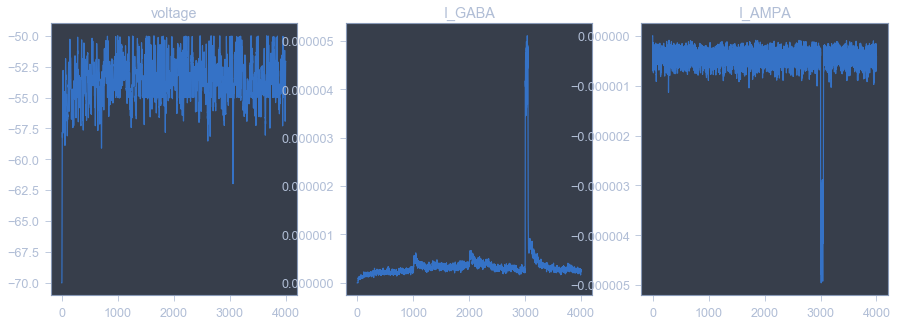

In [5]:
figure(figsize=(15, 5))
subplot(131)
title('voltage')
plot(test.t/ms, test.v[0]/mA)
subplot(132)
title('I_GABA')
plot(test.t/ms, test.I_GABA_rec[0]/mA)
subplot(133)
title('I_AMPA')
plot(test.t/ms, test.I_AMPA_ext[0]/mA)